# SOLução Fármacos
## Projeto Final - Redes Neurais 2024

<img alt='Logo Projeto' src='logo_projeto_final.jpg' width="300">


## Instituição:
- Centro Nacional de Pesquisa em Energia e Materiais
- Ilum - Escola de Ciência

## Alunos:
- Gabriela Fajtag
- Lais Ruela
- João Pedro Mariano

## Professor:
- Daniel Cassar

## Introdução

Nosso dataset é um conjunto de 1128 exemplos contendo informações estruturais e de solubilidade de moléculas. Esse dataset vem da biblioteca `DeepChem` onde há o um conjunto de dados do `MoleculeNet`, uma ferramenta bastante importante no estudo de Aprendizado de Máquina nas Ciências Naturais e Saúde.[<sup>[1]</sup>](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html)[<sup>[2]</sup>](https://arxiv.org/abs/1703.00564).

Este trabalho utiliza um dataset chamado `Delaney`, com mesmo sobrenome do autor de um artigo que descreve um método simples para estimar a solubilidade aquosa. Este modelo é o ESOL e calcula a solubilidade de um composto diretamente a partir de sua estrutura. O modelo foi derivado de um conjunto de 2.874 solubilidades medidas em laboratório e o método utilizado foram regressões lineares com nove propriedades moleculares. O parâmetro mais significativo foi o logP calculado, seguido pelo peso molecular, proporção de átomos pesados em sistemas aromáticos e número de ligações rotacionáveis.[<sup>[3]</sup>](https://pubs.acs.org/doi/10.1021/ci034243x) Nesse notebook, criaremos um modelo para prever solubilidade molecular, ou seja, **logS**.
 
O logP calculado ou cLogP é um termo utilizado para quando calculamos o LogP a partir de alguns parâmetros dados compostos, geralmente utilizando métodos computacionais. Por sua vez, LogP é uma medida logarítimica da partição de concentração de um composto em Octanol (solvente apolar) ou Água (solvente polar). O ESOL é um método que gera o logS,  que utiliza cLogP como parâmetro mais significativo. O modelo apresentou desempenho consistentemente bom em três conjuntos de validação e foi competitivo com a bem estabelecida "Equação de Solubilidade Geral" para moléculas de tamanho medicinais/agroquímicos. [<sup>[3]</sup>](https://pubs.acs.org/doi/10.1021/ci034243x)
 
Porém, no nosso modelo, não utilizaremos do cLogP. Queremos obsevar como a previsão se comporta excluindo o que seria o parâmetro mais importante estudado por John Delaney. Utilizando apenas os parâmetros moleculares e uma Rede Neural do tipo MLP para calcular o nosso próprio `LogS` e comparar os valores reais medidos em laboratório com os valores previstos para saber se é um bom modelo.


## Rede Neural MultiLayer Perceptron

### Importações

In [3]:
#Importações necessárias para este Notebook

from rdkit import Chem
from rdkit.Chem import Descriptors
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import optuna

### Dataset

Importamos o nosso dataset `delaney` do link do github com a biblioteca `pandas`. Podemos perceber que é um bom dataset para o nosso objetivo de prever solubilidade, pois, há informações químicas que dizem respeito do quanto a molécula interage com o meio polar ou apolar. Por exemplo, esperamos que com o maior número de `Number of H-Bond Donors` tenhamos maior tendência à solubilidade em Água, por conta da interação de ligações de Hidrogênio, e com maior `Number of Rings`, tenhamos maior tendência à solubilidade em Octanol, por conta da interação de Van der Walls. Além disso, este dataset contem o valor previsto por Delaney com o método ESOL e o valor real de partição logP medido em mol/L.

In [4]:
#Importação e print do dataset Delaney
df = pd.read_csv("https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv")
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


### Exploração de dados

  Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.32   
1           

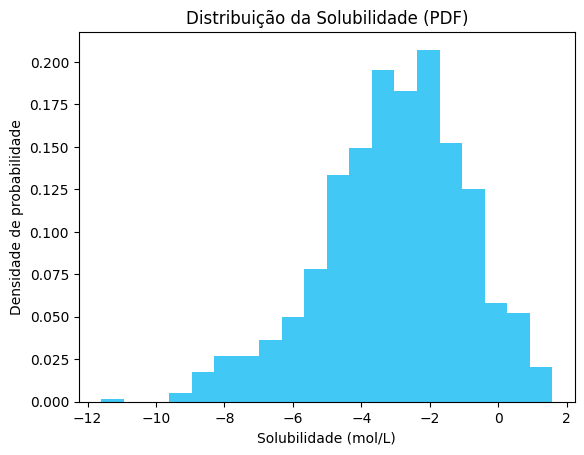

In [26]:
# Visualizar as primeiras linhas do conjunto de dados
print(df.head())
 
# Verificar estatísticas descritivas
print(df.describe())
 
plt.hist(df['measured log solubility in mols per litre'], bins=20, color='#42c8f5', density=True)
plt.xlabel('Solubilidade (mol/L)')
plt.ylabel('Densidade de probabilidade')
plt.title('Distribuição da Solubilidade (PDF)')
plt.show()

Vemos que temos muitas solubilidades negativas. Isso porque os valores de solubilidade do ESOL foram descritos como concentração molar logarítmica (logS), variando de −11,6 a 6,04. Um valor de logS negativo indica baixa solubilidade, enquanto um valor positivo indica alta solubilidade [<sup>[9]</sup>](https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2023.1255181/full)

### Incluindo aromaticidade no `df`

Os aneis das moléculas, por si só, não nos dizem muito sobre a característica hidrofóbica. Isso ocorre
pois os aneis podem ter apenas Carbono e Hidrogênio ou ter heteroátomos, como Nitrogênio ou Oxigênio, que são mais polares. No entanto, uma outra característica importante para a solubilidade é a aromaticidade desses aneis. Em geral, compostos aromáticos são mais hidrofóbicos por fazerem mais interações de Van der Walls.

Então, usando as representações de string das moléculas, ou seja, os **SMILES**, e o módulo `Chem` do `RDKit`, calculamos a proporção de átomos aromáticos em cada molécula e adiciona essa proporção como uma nova coluna no DataFrame Delaney.

Primeiramente, para molécula em SMILES, percorremos um loop aplicando a função `Chem.MolFromSmiles()`, que converte uma string em um objeto `Mol` do `RDKit`. Este objeto é adicionado à lista `mol_list`.

Em seguida, definimos uma função `AromaticAtoms()` que recebe uma molécula em formato de objeto `Mol`, como argumento `m`. A função percorre todos os átomos na molécula com outra função: `m.GetNumAtoms()` que fornece o número total de átomos na molécula. Então, Para cada átomo, a função `m.GetAtomWithIdx(i).GetIsAromatic()` verifica se o átomo é aromático ou não, criando uma lista booleana `aromatic_atoms`. Por fim, calculamos a soma dos átomos aromáticos com `sum(aromatic_atoms)` e retornamos esse valor como `aa_count`.

Por fim, o percorremos um loop para cada molécula em `mol_list` onde chamamos a função `AromaticAtoms()` pré definida e dividimos o número de átomos aromáticos pelo número total de "átomos pesados" (sem o Hidrogênio), na molécula, com a função `Descriptors.HeavyAtomCount(mol)`. Não contamos o Hidrogênio, pois para esta proporção a condição de arômaticidade requer **orbitais p não ligantes** e o Hidrogênio só tem **orbital s**. A proporção aromática `AP` é calculada  e o loop adiciona na lista `AP_list` e então, adicionamos esses valores em uma nova coluna no `df`. O código foi baseado na referência [10]

In [5]:
# Definindo lista de obtetos mol"
mol_list= []
for element in df["smiles"]:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

# Definindo função que calcula o número de átomos aromáticos "
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = sum(aromatic_atoms)
  return aa_count

# Calculando proporção AP em para cada molécula"
AP_list = []
for mol in mol_list:
    AP = AromaticAtoms(mol)/Descriptors.HeavyAtomCount(mol)
    AP_list.append(AP)

# Acrescentando ao dataframe a coluna de "Aromatic proportion"
df["Aromatic proportion"] = AP_list
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Aromatic proportion
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,0.187500
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,0.733333
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),0.000000
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,1.000000
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,0.000000
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,0.000000
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,0.000000
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,0.000000


### Features e Target

Para definir nossas features, precisamos "limpar" este nosso dataset.

`list(df.columns)` cria uma lista contendo os nomes de todas as colunas no DataFrame df. Então, usamos `.remove` para deixar apenas os itens features e, em seguida, voltamos a lista para dataframe com `df[columnsX]`. agora `X` são nossas features!

In [6]:
# Criando um "X" que será as features

columnsX = list(df.columns)
print(columnsX)
print()
columnsX.remove('Compound ID')
columnsX.remove('ESOL predicted log solubility in mols per litre')
columnsX.remove('measured log solubility in mols per litre')
columnsX.remove('smiles')
print()
print(columnsX)
print()
X = df[columnsX]
X

['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles', 'Aromatic proportion']


['Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'Aromatic proportion']



,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,Aromatic proportion
0,1,457.432,7,3,7,202.32,0.187500
1,1,201.225,1,2,2,42.24,0.733333
2,1,152.237,0,0,4,17.07,0.000000
3,2,278.354,0,5,0,0.00,1.000000
4,2,84.143,0,1,0,0.00,1.000000
...,...,...,...,...,...,...,...
1123,1,197.381,0,0,0,0.00,0.000000
1124,1,219.266,1,0,1,71.00,0.000000
1125,1,246.359,0,0,7,18.46,0.000000
1126,1,72.151,0,0,1,0.00,0.000000


Como queremos nos aproximar da dos valores experimentais de solubilidade, o nosso target `y` é `df[["measured log solubility in mols per litre"]]`.

In [7]:
# Criando o "y" para o target

y = df[["measured log solubility in mols per litre"]]
y

,measured log solubility in mols per litre
0,-0.770
1,-3.300
2,-2.060
3,-7.870
4,-1.330
...,...
1123,-1.710
1124,0.106
1125,-3.091
1126,-3.180


### Split: treino, teste e validação

Para garantir a reprodutibilidade, nossa `random_state`(semente aleatória) será:<font color="red"> 61455</font>.

Da biblioteca `scikit-learn` a função `train_test_split` divide nossos dados em subconjuntos de **treino**, **teste** e **validação**. Isso acontece dividindo os dados `X` e `y` em conjuntos de `X_treino`, `y_treino`, `X_teste`, `y_teste`, `X_val` e `y_val`, com `test_size=0.2` 

In [8]:
# Dividindo os dados em treino, teste e validação

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=61455)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, random_state=61455)

### Normalização

Novamente da biblioteca `scikit-learn`, utilizamos `MaxAbsScaler()` definindo como `x_scaler` e `y_scaler`(escaladores) para os dados de `X` e `y`. Adotamos a normalização entre **[-1 , 1]**, pelo fato da importância da preservação dos valores zero (queremos que as grandezas que são zero, para cada exemplo, continuem sendo zero após a normalização). Além disso, os dados devem ser normalizados para que a proporção de importância seja similar no modelo, visto que, alguns dados têm discrepância muito grande de ordem de grandeza como `Number of Rotatable Bonds` e `Polar Surface Area`.

`.fit()` ajusta os escaladores às dimensões de `X` e `y`, calculando os valores máximo e mínimo dos dados, para determinar a escala apropriada da normalização. Então, para treino, teste e validação aplicamos a normalização em si com o `transform()` .

In [9]:
# Normalizando os dados

x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

Neste momento, transformamos os conjuntos de dados em **tensores** - estrutura de dados multidimensional usada no `PyTorch` -. Os tensores gerados são do tipo `torch.float32` - dado `float` de **32 bits**:

### Preparação para MLP: tensores e classe

In [10]:
# Transformando os conjuntos de dados em tensores

X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

`PyTorch Lightning` é uma biblioteca desenvolvida e bastante usual para pesquisadores e profissionais na área de deep learning, Inteligência artificial etc. Ela tem módulos, funções classes, dentre outros que serão úteis para nossa aplicação em Redes Neurais [<sup>[4]</sup>](https://lightning.ai/docs/pytorch/stable/).

Para começar, vamos criar uma classe `DataModule` que herda a classe `LightningDataModule` da biblioteca `PyTorch Lightning`. Com isso, essa nova classe deve implementar métodos para retornar **dataloaders** para treinamento, validação e teste. Esses **dataloaders** são ferramentas do PyTorch que permitem carregar dados em **lotes** (lotes ou batches são conjuntos dos dados usados durante o treino, teste ou validação de um modelo. Ao invés de processar todos os dados de uma vez, o que pode ser inviável para vários dados, eles são divididos em lotes menores que "alimentados" o modelo em cada iteração).

O método dunder `__init__` recebe os dados de treino, teste e validação, armazenando como atributos de instância: `self.X_treino`, `self.y_treino`, etc. Recebe, também, parâmetros da função `DataLoader`: `tamanho_lote` e `num_trabalhadores` - utilizado para transformar os dados em tensores e dividí-los em lotes. Além de utilizar como padrão o argumento `self`, recebe `super().__init__()` da herança.

O método `train_dataloader()` retorna a função `DataLoader` para o conjunto de treino. Na função em questão, `TensorDataset` utiliza `X_treino` e `y_treino` e aplica os lotes e os trabalhadores com:

`batch_size=self.tamanho_lote,`

`num_workers=self.num_trabalhadores,`

`persistent_workers=True`

Fazendo da mesma forma para teste e validação com `val_dataloader()` e `test_dataloader()`.

In [11]:
# Criando instância de L.LightningDataModule, utilizada durante o treino da rede pelo PyTorch Lightning

class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 128,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

### MLP

#### Explicação detalhada da MLP

Para a nossa classe `MPL` de Rede Neural MultiLayer Perceptron, usamos herança da classe `LightningModule` 

- Aqui o dunder `__init__` recebe de argumentos:
`self`, 
`num_dados_entrada` que são o número de features de entrada,
`neuronios`: que é uma lista que diz o número de neurônios em cada camada oculta,
`num_saida`: que é o número de neurônios na camada de saída,
`lr`: que é a taxa de aprendizado para o otimizador.

Ainda nessa função da calsse, temos que `nn`, `F` e `optim`são os módulos `torch.nn`, `torch.nn.functional` e `torch.optim`, que definem e fornecem Redes Neurais, Funções e Otimizadores, respectivamente (definidos no início do Notebook, em **importações**).

Continuando com as definições,
- `todas_as_camadas` é uma lista, começando vazia, e que armazena as camadas da rede neural.

- **primeira camada:**
A primeira camada é uma camada que conecta, por operações lineares pela função `nn.Linear`, os inputs `num_dados_entrada` à primeira camada oculta `neuronios[0]`. Após isso, adicionamos a função de ativação `nn.ReLU()` (Rectified Linear Unit) à saída desta camada linear pela sua eficiencia e boa aplicabilidade em Redes Neurais[<sup>[5]</sup>](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

- **loop de camadas ocultas:** O loop `for i in range(len(neuronios)-1)` percorre as camadas ocultas, começando pela primeira e terminando na penúltima camada, excluindo a última que é a camada de saída. Em cada iteração, uma camada linear (**nn.Linear**) é criada conectando a saída da camada `neuronios[i]` à entrada da próxima camada `neuronios[i+1]`. Adiciona-se essa camada e depois uma função `nn.ReLU()`.

- **camada de saída:** A camada de saída é, também, uma camada linear (**nn.Linear**) que conecta a última camada oculta `neuronios[-1]` à camada de saída `num_saida`.

Finalizando a definição das camadas, elas são agrupadas em um objeto `nn.Sequential`, que é armazenado em `self.camadas`.

- **Função de Perda** é armazendada por `self.fun_perda = F.mse_loss` utilizando o Erro Quadrático Médio, do Inglês: **MSE**.

- **Taxa de Aprendizado** é armazenada por `self.lr = lr` armazena a taxa de aprendizado especificada.
Listas para Armazenar Perdas:

- `self.perdas_trein` e `self.perdas_val` são listas que começam vazias e armazenam as perdas durante o treino e validação, respectivamente.

- `self.curva_aprendizado_treino` e `self.curva_aprendizado_val` são listas que começam vazias e armazenam as médias das perdas de treinamento e validação ao final de cada **época**.

- A função `forward` recebe um tensor de entrada `X` e o prapaga em `self.camadas`. O return é o tensor de saída, ou seja, a previsão de solubilidade.

- A função `training_step` é chamada durante cada iteração do treinamento para processar um lote. Faz uma previsão de `y_pred` para a entrada `x` usando `forward`. Calcula a perda `loss` entre `y_pred` e `y` usando `self.fun_perda` (MSE).Registra a perda com `self.log("loss", loss, prog_bar=True)` e depois, adiciona a perda à lista `self.perdas_treino` para acompanhá-las durante o treino. Por fim, o return é o `loss`.

- As funções `test_step` e `validation_step` funcionam de forma análoga à `training_step`.

- `on_train_epoch_end` e `on_validation_epoch_end` são funções que ao final de cada época de treino, calculam a perda média para os lotes processados durante a época usando `torch.stack().mean()` e adicionando a perda média à respectiva curva de aprendizado. Por fim, limpam suas listas para a próxima época.

- Como ultima função da classe, temos `configure_optimizers` que configura o otimizador `.Adam` usado no modelo. a função usa o otimizador com a taxa de aprendizado `self.lr` e tem como return o otimizador, que será usado para otimizar os parâmetros.

#### Criando e rodando a MLP

In [12]:
# Criando a Rede Neural MLP

class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios, num_saida, lr
    ):
        super().__init__()
        
        todas_as_camadas = []
        todas_as_camadas.append(nn.Linear(num_dados_entrada, neuronios[0]))
        todas_as_camadas.append(nn.ReLU())
        for i in range(len(neuronios)-1):
            camada = nn.Linear(neuronios[i], neuronios[i+1])
            todas_as_camadas.append(camada)
            todas_as_camadas.append(nn.ReLU())
        todas_as_camadas.append(nn.Linear(neuronios[-1], num_saida))

        self.camadas = nn.Sequential(*todas_as_camadas)

        self.fun_perda = F.mse_loss
        self.lr = lr

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)
        return optimizer

Neste caso usamos o `L.Trainer` é uma classe da biblioteca PyTorch Lightning que junta o processo de treinamento, validação e teste de um modelo. Então usamos para 100 épocas. `dm` é a classe `DataMolude` que recebe todos os dados e fornece os dataloades para realizar o treino, teste e validação. Então, `minha_MLP` é a nossa rede que tem **7 features**, **2 camadas** ocultas com **20 e 10 neurônios**, **1 neurônio de saída** - o resultado da solubilidade - e uma **taxa de aprendizado de 0.001**.

In [13]:
# Treinando o teste

treinador = L.Trainer(max_epochs=100)
dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
minha_MLP = MLP(7, [20,10], 1, 1e-3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`treinador` é um objeto da classe `L.Trainer` que usamos aqui para iniciar o modelo de rede neural usando a `minha_MLP`  e o `dm`.

In [14]:
treinador.fit(minha_MLP, dm)


  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 381   
---------------------------------------
381       Trainable params
0         Non-trainable params
381       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


### Compreendendo a Rede Neural

Os modelos de previsão, como as Redes Neurais têm que ser treinados e testados. Um ótimo modelo tem baixo erro (loss) em seu treino pois ele consegue ajustar-se bem ao seu daframe de treino e baixo erro usando dados fora do daframe de treino, pois ele consegue acertar dados que ele não obteve na hora de treinar. Então, ao passar das épocas, espera-se que o modelo diminua o erro tanto no treino, quanto na validação, porém que a curva de validação esteja acima da curva de teste, pois, esperamos que ele erre mais na hora de aplicar um modelo para uma molécula que ele nunca "viu".[<sup>[6]</sup>](https://www.youtube.com/watch?v=nt5DwCuYY5c&t=288s)[<sup>[7]</sup>](https://www.youtube.com/watch?v=p3CcfIjycBA&t=762s) É o que percebemos com o nosso modelo com o plot a seguir utilizando a biblioteca `matplotlib`.

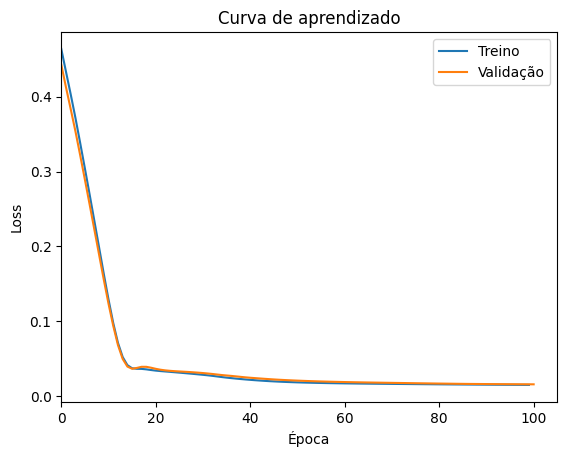

In [15]:
# Plotando a curva de aprendizado

figura, eixo = plt.subplots()

ca_treino = minha_MLP.curva_aprendizado_treino
ca_val = minha_MLP.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

Primeiro, com `minha_MLP.eval()` interrompemos operações de treinamento e coloca o modelo em modo de teste. e com `with torch.no_grad()` desativamos o cálculo de gradientes para operações dentro deste bloco `with`, pois não há necessidade e melhora o desempenho computacional. Posteriormente, `inverse_transform()` invertemos a normalização do `y_true` e `y_pred` para os dados originais. Por fim, o cálculo da Raiz do Erro Quadrado Médio (do inglês, RMSE) foi utilizada como métrica das solubilidades previstas por esse modelo. O Print o RMSE é visto no código a seguir:

In [16]:
# Avaliando o modelo

minha_MLP.eval()

with torch.no_grad():
    X_true = X_teste

    y_true = y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = minha_MLP(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

1.0809028872471145


Por fim, podemos ver a dispersão desses dados com o plot do gráfico.

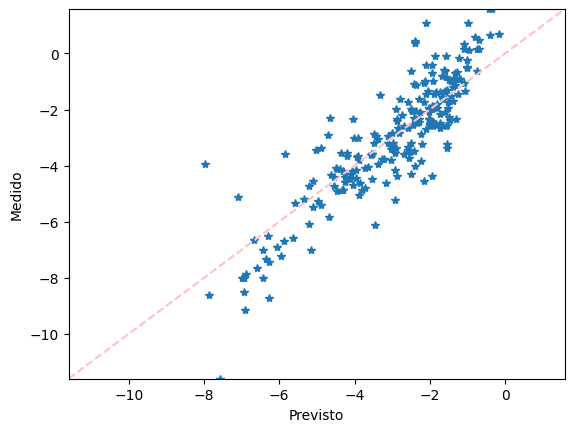

In [17]:
# Gráfico de previsto x verdadeiro

plt.plot(y_pred, y_true,"*")

min_valor = min([y_true.min(),y_pred.min()])
max_valor = max([y_true.max(),y_pred.max()])


plt.xlim(min_valor,max_valor)
plt.ylim(min_valor,max_valor)
plt.plot([min_valor,max_valor],[min_valor,max_valor],"--",color="pink")
plt.xlabel("Previsto")
plt.ylabel("Medido")
plt.show()

Neste gráfico, os valores medidos e previstos de logS são dados na unidade de mol/L.

## Otimização MLP

Usando a biblioteca `Optuna`, vamos otimizar os hiperparâmetros com uma abordagem que consiste em testar diferentes configurações para encontrar a melhor arquitetura possível usando os métodos dessa biblioteca especializada em otimização.[<sup>[8]</sup>](https://optuna.org/) Vamos testas 150 configurações diferentes de arquitetura, variando o número de camadas ocultas, neurônios por camada e taxa de aprendizado, e procura minimizar a perda de validação.

Primeiro, definimos a função `objective` que recebe um objeto `trial` que é usado para sugerir hiperparâmetros aleatórios. Depois: `camadas = trial.suggest_int('num_camadas', 1, 5)` sugere o número de camadas entre 1 e 5; `hidden.append(trial.suggest_int(f'neuronios_c{i}', 4, 64))`, para cada camada oculta, sugere um número de neurônios entre 4 e 64; `learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)` sugere uma taxa de aprendizado entre 1e-5 e 1e-2.

Além disso,`treinador = L.Trainer(max_epochs=200, callbacks=[EarlyStopping(monitor="val_loss", mode="min")])`
esta parte da função inicializa um treinador de PyTorch Lightning com um máximo de 200 épocas e um **callback** de parada antecipada (EarlyStopping) para monitorar a perda de validação.

Então, ciamos uma MLP, ainda dentro da função, com esses hiperparâmetros a serem escolhidos pelo Optuna: `minha_MLP = MLP(7, hidden, 1, learning_rate)` com treinamento `treinador.fit(minha_MLP, dm)` e, por fim, com return da perda de validação com `return treinador.callback_metrics["val_loss"].item()`, que é usada pelo Optuna para otimizar os hiperparâmetros.

Para execução da otimização `study = optuna.create_study(...)` cria um estudo de Optuna com o objetivo de minimizar a perda de validação com `minimize`. `study.optimize(objective, n_trials=150)` executa a otimização por 150 tentativas, testando diferentes hiperparâmetros.

e como resultados, são printados `best_params = study.best_param` e `best_loss = study.best_value`

In [16]:
# Otimizando a rede com Optuna testando 150 arquiteturas diferentes, variando quantidade de camada e 
# quantidade de neurônios por camada.

dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

def objective(trial):
    camadas = trial.suggest_int('num_camadas', 1, 5)
    hidden = []
    for i in range(camadas):
        hidden.append(trial.suggest_int(f'neuronios_c{i}', 4, 64))
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    
    treinador = L.Trainer(max_epochs=200,callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
    minha_MLP = MLP(7, hidden, 1, learning_rate)
    treinador.fit(minha_MLP, dm)
    
    return treinador.callback_metrics["val_loss"].item()


#Criando um objeto de estudo para salvar os hiperparâmetros encontrados pelo Optuna
study = optuna.create_study(direction='minimize',
                            storage="sqlite:///db.sqlite3",
                            study_name="Sol_study",load_if_exists=True
    )
study.optimize(objective, n_trials=150)

best_params = study.best_params
best_loss = study.best_value

print("Melhores hiperparâmetros encontrados:", best_params)
print("Melhor perda -loss- encontrada:", best_loss)

c:\Users\guida\anaconda3\envs\env_ic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-07 00:16:38,771] A new study created in RDB with name: Sol_study
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.1 K 
---------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


c:\Users\guida\anaconda3\envs\env_ic\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 28: 100%|██████████| 6/6 [00:00<00:00, 139.54it/s, v_num=1, loss=0.00817, val_loss=0.0109]


[I 2024-05-07 00:16:46,018] Trial 0 finished with value: 0.010919732041656971 and parameters: {'num_camadas': 3, 'neuronios_c0': 49, 'neuronios_c1': 62, 'neuronios_c2': 41, 'learning_rate': 0.004644243310200764}. Best is trial 0 with value: 0.010919732041656971.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.0 K 
---------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Epoch 59: 100%|██████████| 6/6 [00:00<00:00, 143.28it/s, v_num=2, loss=0.00664, val_loss=0.00875]


[I 2024-05-07 00:16:54,668] Trial 1 finished with value: 0.00875046942383051 and parameters: {'num_camadas': 3, 'neuronios_c0': 19, 'neuronios_c1': 55, 'neuronios_c2': 31, 'learning_rate': 0.0069910855070535}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 6/6 [00:00<00:00, 124.87it/s, v_num=3, loss=0.00966, val_loss=0.0145]


[I 2024-05-07 00:17:01,191] Trial 2 finished with value: 0.01453668624162674 and parameters: {'num_camadas': 3, 'neuronios_c0': 40, 'neuronios_c1': 27, 'neuronios_c2': 39, 'learning_rate': 0.009465725986003318}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.2 K 
---------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Epoch 13: 100%|██████████| 6/6 [00:00<00:00, 127.68it/s, v_num=4, loss=0.0093, val_loss=0.0152]


[I 2024-05-07 00:17:08,046] Trial 3 finished with value: 0.01517216581851244 and parameters: {'num_camadas': 3, 'neuronios_c0': 63, 'neuronios_c1': 45, 'neuronios_c2': 60, 'learning_rate': 0.008835438949903598}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.9 K 
---------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 117.66it/s, v_num=5, loss=0.013, val_loss=0.0179] 


[I 2024-05-07 00:17:15,043] Trial 4 finished with value: 0.017905594781041145 and parameters: {'num_camadas': 5, 'neuronios_c0': 9, 'neuronios_c1': 31, 'neuronios_c2': 24, 'neuronios_c3': 30, 'neuronios_c4': 32, 'learning_rate': 0.008818116760755583}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.6 K 
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 40: 100%|██████████| 6/6 [00:00<00:00, 103.72it/s, v_num=6, loss=0.00791, val_loss=0.00968]


[I 2024-05-07 00:17:23,206] Trial 5 finished with value: 0.009681753814220428 and parameters: {'num_camadas': 3, 'neuronios_c0': 16, 'neuronios_c1': 60, 'neuronios_c2': 55, 'learning_rate': 0.005593104738456723}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.3 K 
---------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Epoch 37: 100%|██████████| 6/6 [00:00<00:00, 122.37it/s, v_num=7, loss=0.00778, val_loss=0.0095] 


[I 2024-05-07 00:17:31,094] Trial 6 finished with value: 0.009502025321125984 and parameters: {'num_camadas': 2, 'neuronios_c0': 62, 'neuronios_c1': 60, 'learning_rate': 0.0068621472805480595}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 851   
---------------------------------------
851       Trainable params
0         Non-trainable params
851       Total params
0.003     Total estimated model params size (MB)


Epoch 93: 100%|██████████| 6/6 [00:00<00:00, 120.01it/s, v_num=8, loss=0.00788, val_loss=0.00919]


[I 2024-05-07 00:17:41,763] Trial 7 finished with value: 0.00919445138424635 and parameters: {'num_camadas': 3, 'neuronios_c0': 19, 'neuronios_c1': 16, 'neuronios_c2': 21, 'learning_rate': 0.0050299454424155956}. Best is trial 1 with value: 0.00875046942383051.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 461   
---------------------------------------
461       Trainable params
0         Non-trainable params
461       Total params
0.002     Total estimated model params size (MB)


Epoch 103: 100%|██████████| 6/6 [00:00<00:00, 108.09it/s, v_num=9, loss=0.00731, val_loss=0.00826]


[I 2024-05-07 00:17:52,734] Trial 8 finished with value: 0.008264674805104733 and parameters: {'num_camadas': 2, 'neuronios_c0': 26, 'neuronios_c1': 9, 'learning_rate': 0.0036201031594356404}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 321   
---------------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)


Epoch 81: 100%|██████████| 6/6 [00:00<00:00, 119.23it/s, v_num=10, loss=0.00913, val_loss=0.0109]


[I 2024-05-07 00:18:02,687] Trial 9 finished with value: 0.010932202450931072 and parameters: {'num_camadas': 2, 'neuronios_c0': 26, 'neuronios_c1': 4, 'learning_rate': 0.0049856918099790495}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 325   
---------------------------------------
325       Trainable params
0         Non-trainable params
325       Total params
0.001     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 166.66it/s, v_num=11, loss=0.00746, val_loss=0.00989]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 146.34it/s, v_num=11, loss=0.00746, val_loss=0.00989]


[I 2024-05-07 00:18:17,373] Trial 10 finished with value: 0.009890859015285969 and parameters: {'num_camadas': 1, 'neuronios_c0': 36, 'learning_rate': 0.0019430460209235285}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.0 K 
---------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Epoch 82: 100%|██████████| 6/6 [00:00<00:00, 119.82it/s, v_num=12, loss=0.0131, val_loss=0.0153]


[I 2024-05-07 00:18:27,634] Trial 11 finished with value: 0.01530804205685854 and parameters: {'num_camadas': 5, 'neuronios_c0': 5, 'neuronios_c1': 47, 'neuronios_c2': 7, 'neuronios_c3': 63, 'neuronios_c4': 59, 'learning_rate': 0.0024955723198643405}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 235   
---------------------------------------
235       Trainable params
0         Non-trainable params
235       Total params
0.001     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 164.37it/s, v_num=13, loss=0.0121, val_loss=0.0142]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 148.14it/s, v_num=13, loss=0.0121, val_loss=0.0142]


[I 2024-05-07 00:18:41,893] Trial 12 finished with value: 0.014171947725117207 and parameters: {'num_camadas': 1, 'neuronios_c0': 26, 'learning_rate': 0.00046102255704493335}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 362   
---------------------------------------
362       Trainable params
0         Non-trainable params
362       Total params
0.001     Total estimated model params size (MB)


Epoch 120: 100%|██████████| 6/6 [00:00<00:00, 119.64it/s, v_num=14, loss=0.00856, val_loss=0.00975]


[I 2024-05-07 00:18:53,655] Trial 13 finished with value: 0.009749309159815311 and parameters: {'num_camadas': 2, 'neuronios_c0': 27, 'neuronios_c1': 5, 'learning_rate': 0.007095711917409124}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 110: 100%|██████████| 6/6 [00:00<00:00, 115.40it/s, v_num=15, loss=0.00768, val_loss=0.00879]


[I 2024-05-07 00:19:05,717] Trial 14 finished with value: 0.008786843158304691 and parameters: {'num_camadas': 4, 'neuronios_c0': 15, 'neuronios_c1': 46, 'neuronios_c2': 25, 'neuronios_c3': 6, 'learning_rate': 0.002754152055232684}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.8 K 
---------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 6/6 [00:00<00:00, 115.40it/s, v_num=16, loss=0.0475, val_loss=0.0497]


[I 2024-05-07 00:19:12,364] Trial 15 finished with value: 0.049737315624952316 and parameters: {'num_camadas': 4, 'neuronios_c0': 46, 'neuronios_c1': 20, 'neuronios_c2': 4, 'neuronios_c3': 60, 'learning_rate': 0.0036867951633975868}. Best is trial 8 with value: 0.008264674805104733.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Epoch 171: 100%|██████████| 6/6 [00:00<00:00, 115.39it/s, v_num=17, loss=0.00678, val_loss=0.00791]


[I 2024-05-07 00:19:26,590] Trial 16 finished with value: 0.007911605760455132 and parameters: {'num_camadas': 2, 'neuronios_c0': 30, 'neuronios_c1': 38, 'learning_rate': 0.006468377861584512}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Epoch 103: 100%|██████████| 6/6 [00:00<00:00, 129.00it/s, v_num=18, loss=0.00582, val_loss=0.0081] 


[I 2024-05-07 00:19:37,519] Trial 17 finished with value: 0.008098211139440536 and parameters: {'num_camadas': 2, 'neuronios_c0': 30, 'neuronios_c1': 37, 'learning_rate': 0.0040121682898629826}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 298   
---------------------------------------
298       Trainable params
0         Non-trainable params
298       Total params
0.001     Total estimated model params size (MB)


Epoch 94: 100%|██████████| 6/6 [00:00<00:00, 130.43it/s, v_num=19, loss=0.00837, val_loss=0.00899]


[I 2024-05-07 00:19:47,839] Trial 18 finished with value: 0.008990996517241001 and parameters: {'num_camadas': 1, 'neuronios_c0': 33, 'learning_rate': 0.006543254982821688}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 126.28it/s, v_num=20, loss=0.00865, val_loss=0.0127]


[I 2024-05-07 00:19:54,736] Trial 19 finished with value: 0.012689432129263878 and parameters: {'num_camadas': 2, 'neuronios_c0': 50, 'neuronios_c1': 39, 'learning_rate': 0.008114739220635929}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.0 K 
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 118.80it/s, v_num=21, loss=0.00584, val_loss=0.00867]


[I 2024-05-07 00:20:02,474] Trial 20 finished with value: 0.008674178272485733 and parameters: {'num_camadas': 4, 'neuronios_c0': 40, 'neuronios_c1': 37, 'neuronios_c2': 49, 'neuronios_c3': 6, 'learning_rate': 0.009982180184411615}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.1 K 
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 173: 100%|██████████| 6/6 [00:00<00:00, 122.46it/s, v_num=22, loss=0.00786, val_loss=0.00874]


[I 2024-05-07 00:20:16,933] Trial 21 finished with value: 0.008738716132938862 and parameters: {'num_camadas': 2, 'neuronios_c0': 31, 'neuronios_c1': 25, 'learning_rate': 0.00391119729506163}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 465   
---------------------------------------
465       Trainable params
0         Non-trainable params
465       Total params
0.002     Total estimated model params size (MB)


Epoch 62: 100%|██████████| 6/6 [00:00<00:00, 112.12it/s, v_num=23, loss=0.00993, val_loss=0.0109]


[I 2024-05-07 00:20:26,030] Trial 22 finished with value: 0.010872479528188705 and parameters: {'num_camadas': 2, 'neuronios_c0': 22, 'neuronios_c1': 12, 'learning_rate': 0.00570046298372286}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 343   
---------------------------------------
343       Trainable params
0         Non-trainable params
343       Total params
0.001     Total estimated model params size (MB)


Epoch 94: 100%|██████████| 6/6 [00:00<00:00, 128.28it/s, v_num=24, loss=0.00751, val_loss=0.00908]


[I 2024-05-07 00:20:36,509] Trial 23 finished with value: 0.009075629524886608 and parameters: {'num_camadas': 1, 'neuronios_c0': 38, 'learning_rate': 0.003980530755894743}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Epoch 90: 100%|██████████| 6/6 [00:00<00:00, 120.01it/s, v_num=25, loss=0.00701, val_loss=0.00872]


[I 2024-05-07 00:20:46,745] Trial 24 finished with value: 0.008723929524421692 and parameters: {'num_camadas': 2, 'neuronios_c0': 31, 'neuronios_c1': 34, 'learning_rate': 0.005758278546228163}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 217   
---------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 134.80it/s, v_num=26, loss=0.007, val_loss=0.00855]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 112.14it/s, v_num=26, loss=0.007, val_loss=0.00855]


[I 2024-05-07 00:21:01,579] Trial 25 finished with value: 0.00855386070907116 and parameters: {'num_camadas': 1, 'neuronios_c0': 24, 'learning_rate': 0.00429383089295124}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 71: 100%|██████████| 6/6 [00:00<00:00, 139.55it/s, v_num=27, loss=0.00726, val_loss=0.00879]


[I 2024-05-07 00:21:10,701] Trial 26 finished with value: 0.008787423372268677 and parameters: {'num_camadas': 2, 'neuronios_c0': 45, 'neuronios_c1': 41, 'learning_rate': 0.003215978319960332}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 128: 100%|██████████| 6/6 [00:00<00:00, 142.85it/s, v_num=28, loss=0.00693, val_loss=0.00865]


[I 2024-05-07 00:21:22,294] Trial 27 finished with value: 0.008647562004625797 and parameters: {'num_camadas': 2, 'neuronios_c0': 31, 'neuronios_c1': 53, 'learning_rate': 0.003204867175782757}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 109   
---------------------------------------
109       Trainable params
0         Non-trainable params
109       Total params
0.000     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 157.93it/s, v_num=29, loss=0.0117, val_loss=0.0142]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 139.56it/s, v_num=29, loss=0.0117, val_loss=0.0142]


[I 2024-05-07 00:21:36,690] Trial 28 finished with value: 0.014221606776118279 and parameters: {'num_camadas': 1, 'neuronios_c0': 12, 'learning_rate': 0.0018871938179818087}. Best is trial 16 with value: 0.007911605760455132.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.9 K 
---------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 122: 100%|██████████| 6/6 [00:00<00:00, 112.13it/s, v_num=30, loss=0.00586, val_loss=0.00748]


[I 2024-05-07 00:21:48,833] Trial 29 finished with value: 0.007476270664483309 and parameters: {'num_camadas': 3, 'neuronios_c0': 21, 'neuronios_c1': 30, 'neuronios_c2': 64, 'learning_rate': 0.004690771741923557}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.3 K 
---------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Epoch 44: 100%|██████████| 6/6 [00:00<00:00, 112.13it/s, v_num=31, loss=0.00801, val_loss=0.0108]


[I 2024-05-07 00:21:57,271] Trial 30 finished with value: 0.010787351988255978 and parameters: {'num_camadas': 4, 'neuronios_c0': 53, 'neuronios_c1': 29, 'neuronios_c2': 49, 'neuronios_c3': 36, 'learning_rate': 0.004600411518063402}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 61: 100%|██████████| 6/6 [00:00<00:00, 115.38it/s, v_num=32, loss=0.00775, val_loss=0.0105]


[I 2024-05-07 00:22:06,492] Trial 31 finished with value: 0.010501670651137829 and parameters: {'num_camadas': 3, 'neuronios_c0': 21, 'neuronios_c1': 22, 'neuronios_c2': 63, 'learning_rate': 0.0047580500168249015}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 67: 100%|██████████| 6/6 [00:00<00:00, 126.29it/s, v_num=33, loss=0.00706, val_loss=0.00867]


[I 2024-05-07 00:22:15,846] Trial 32 finished with value: 0.008668429218232632 and parameters: {'num_camadas': 3, 'neuronios_c0': 28, 'neuronios_c1': 33, 'neuronios_c2': 14, 'learning_rate': 0.0042302436665415544}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 384   
---------------------------------------
384       Trainable params
0         Non-trainable params
384       Total params
0.002     Total estimated model params size (MB)


Epoch 75: 100%|██████████| 6/6 [00:00<00:00, 127.21it/s, v_num=34, loss=0.00831, val_loss=0.0094] 


[I 2024-05-07 00:22:25,258] Trial 33 finished with value: 0.009399785660207272 and parameters: {'num_camadas': 2, 'neuronios_c0': 17, 'neuronios_c1': 13, 'learning_rate': 0.006260322228006341}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.9 K 
---------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.015     Total estimated model params size (MB)


Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 129.01it/s, v_num=35, loss=0.00942, val_loss=0.0116]


[I 2024-05-07 00:22:32,838] Trial 34 finished with value: 0.011597502045333385 and parameters: {'num_camadas': 3, 'neuronios_c0': 35, 'neuronios_c1': 42, 'neuronios_c2': 47, 'learning_rate': 0.005180090215647387}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 80: 100%|██████████| 6/6 [00:00<00:00, 136.37it/s, v_num=36, loss=0.00674, val_loss=0.00823]


[I 2024-05-07 00:22:42,482] Trial 35 finished with value: 0.008228623308241367 and parameters: {'num_camadas': 3, 'neuronios_c0': 22, 'neuronios_c1': 35, 'neuronios_c2': 35, 'learning_rate': 0.003542963211105468}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.9 K 
---------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)


Epoch 65: 100%|██████████| 6/6 [00:00<00:00, 119.90it/s, v_num=37, loss=0.00809, val_loss=0.00933]


[I 2024-05-07 00:22:51,512] Trial 36 finished with value: 0.009326150640845299 and parameters: {'num_camadas': 3, 'neuronios_c0': 11, 'neuronios_c1': 37, 'neuronios_c2': 34, 'learning_rate': 0.0043799088631302505}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.4 K 
---------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Epoch 45: 100%|██████████| 6/6 [00:00<00:00, 121.19it/s, v_num=38, loss=0.00785, val_loss=0.00999]


[I 2024-05-07 00:23:00,067] Trial 37 finished with value: 0.009994806721806526 and parameters: {'num_camadas': 4, 'neuronios_c0': 23, 'neuronios_c1': 34, 'neuronios_c2': 58, 'neuronios_c3': 40, 'learning_rate': 0.005358150363231014}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.5 K 
---------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Epoch 47: 100%|██████████| 6/6 [00:00<00:00, 131.85it/s, v_num=39, loss=0.00736, val_loss=0.0089] 


[I 2024-05-07 00:23:08,421] Trial 38 finished with value: 0.008897675201296806 and parameters: {'num_camadas': 3, 'neuronios_c0': 20, 'neuronios_c1': 52, 'neuronios_c2': 41, 'learning_rate': 0.006040076106066999}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 673   
---------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Epoch 119: 100%|██████████| 6/6 [00:00<00:00, 122.46it/s, v_num=40, loss=0.00923, val_loss=0.011] 


[I 2024-05-07 00:23:20,540] Trial 39 finished with value: 0.010973997414112091 and parameters: {'num_camadas': 3, 'neuronios_c0': 6, 'neuronios_c1': 27, 'neuronios_c2': 15, 'learning_rate': 0.004860616734046665}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.6 K 
---------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 115.73it/s, v_num=41, loss=0.0132, val_loss=0.0173]


[I 2024-05-07 00:23:26,929] Trial 40 finished with value: 0.01734844408929348 and parameters: {'num_camadas': 3, 'neuronios_c0': 14, 'neuronios_c1': 49, 'neuronios_c2': 54, 'learning_rate': 0.007274332182662045}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.6 K 
---------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Epoch 88: 100%|██████████| 6/6 [00:00<00:00, 130.72it/s, v_num=42, loss=0.00778, val_loss=0.00869]


[I 2024-05-07 00:23:37,141] Trial 41 finished with value: 0.008686883375048637 and parameters: {'num_camadas': 2, 'neuronios_c0': 29, 'neuronios_c1': 43, 'learning_rate': 0.003412458835076699}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 885   
---------------------------------------
885       Trainable params
0         Non-trainable params
885       Total params
0.004     Total estimated model params size (MB)


Epoch 126: 100%|██████████| 6/6 [00:00<00:00, 131.84it/s, v_num=43, loss=0.00654, val_loss=0.00943]


[I 2024-05-07 00:23:49,161] Trial 42 finished with value: 0.009427722543478012 and parameters: {'num_camadas': 2, 'neuronios_c0': 18, 'neuronios_c1': 37, 'learning_rate': 0.005251159138179177}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.0 K 
---------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Epoch 75: 100%|██████████| 6/6 [00:00<00:00, 100.00it/s, v_num=44, loss=0.00714, val_loss=0.00898]


[I 2024-05-07 00:23:59,064] Trial 43 finished with value: 0.008976290933787823 and parameters: {'num_camadas': 2, 'neuronios_c0': 25, 'neuronios_c1': 31, 'learning_rate': 0.003737500419807057}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 863   
---------------------------------------
863       Trainable params
0         Non-trainable params
863       Total params
0.003     Total estimated model params size (MB)


Epoch 157: 100%|██████████| 6/6 [00:00<00:00, 126.27it/s, v_num=45, loss=0.0061, val_loss=0.00897] 


[I 2024-05-07 00:24:13,043] Trial 44 finished with value: 0.008973523043096066 and parameters: {'num_camadas': 3, 'neuronios_c0': 34, 'neuronios_c1': 8, 'neuronios_c2': 31, 'learning_rate': 0.004549497355624191}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.2 K 
---------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Epoch 43: 100%|██████████| 6/6 [00:00<00:00, 101.22it/s, v_num=46, loss=0.0101, val_loss=0.0127] 


[I 2024-05-07 00:24:21,572] Trial 45 finished with value: 0.012744531966745853 and parameters: {'num_camadas': 5, 'neuronios_c0': 29, 'neuronios_c1': 24, 'neuronios_c2': 45, 'neuronios_c3': 22, 'neuronios_c4': 4, 'learning_rate': 0.0056032372142023334}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 96: 100%|██████████| 6/6 [00:00<00:00, 116.87it/s, v_num=47, loss=0.00595, val_loss=0.00824]


[I 2024-05-07 00:24:32,424] Trial 46 finished with value: 0.008236238732933998 and parameters: {'num_camadas': 3, 'neuronios_c0': 37, 'neuronios_c1': 18, 'neuronios_c2': 63, 'learning_rate': 0.00410487624687304}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.7 K 
---------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Epoch 46: 100%|██████████| 6/6 [00:00<00:00, 113.22it/s, v_num=48, loss=0.00788, val_loss=0.00975]


[I 2024-05-07 00:24:41,053] Trial 47 finished with value: 0.00975153036415577 and parameters: {'num_camadas': 4, 'neuronios_c0': 43, 'neuronios_c1': 20, 'neuronios_c2': 63, 'neuronios_c3': 48, 'learning_rate': 0.0049112385719880325}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.2 K 
---------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Epoch 68: 100%|██████████| 6/6 [00:00<00:00, 129.00it/s, v_num=49, loss=0.00655, val_loss=0.0086] 


[I 2024-05-07 00:24:50,482] Trial 48 finished with value: 0.008598966524004936 and parameters: {'num_camadas': 3, 'neuronios_c0': 38, 'neuronios_c1': 30, 'neuronios_c2': 53, 'learning_rate': 0.004099711557282833}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.5 K 
---------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 74: 100%|██████████| 6/6 [00:00<00:00, 121.18it/s, v_num=50, loss=0.00623, val_loss=0.00856]


[I 2024-05-07 00:25:00,336] Trial 49 finished with value: 0.00856374017894268 and parameters: {'num_camadas': 3, 'neuronios_c0': 56, 'neuronios_c1': 16, 'neuronios_c2': 64, 'learning_rate': 0.00606624514260112}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.4 K 
---------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Epoch 57: 100%|██████████| 6/6 [00:00<00:00, 122.39it/s, v_num=51, loss=0.00787, val_loss=0.00971]


[I 2024-05-07 00:25:09,389] Trial 50 finished with value: 0.009709642268717289 and parameters: {'num_camadas': 3, 'neuronios_c0': 42, 'neuronios_c1': 39, 'neuronios_c2': 59, 'learning_rate': 0.0029057199190569154}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 449   
---------------------------------------
449       Trainable params
0         Non-trainable params
449       Total params
0.002     Total estimated model params size (MB)


Epoch 128: 100%|██████████| 6/6 [00:00<00:00, 133.34it/s, v_num=52, loss=0.00759, val_loss=0.00861]


[I 2024-05-07 00:25:21,461] Trial 51 finished with value: 0.008609982207417488 and parameters: {'num_camadas': 2, 'neuronios_c0': 27, 'neuronios_c1': 8, 'learning_rate': 0.0035981880506631373}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 801   
---------------------------------------
801       Trainable params
0         Non-trainable params
801       Total params
0.003     Total estimated model params size (MB)


Epoch 127: 100%|██████████| 6/6 [00:00<00:00, 123.71it/s, v_num=53, loss=0.00724, val_loss=0.00908]


[I 2024-05-07 00:25:33,688] Trial 52 finished with value: 0.009082675911486149 and parameters: {'num_camadas': 2, 'neuronios_c0': 32, 'neuronios_c1': 16, 'learning_rate': 0.0039880439187287625}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.6 K 
---------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Epoch 102: 100%|██████████| 6/6 [00:00<00:00, 120.02it/s, v_num=54, loss=0.00705, val_loss=0.00855]


[I 2024-05-07 00:25:44,474] Trial 53 finished with value: 0.008550336584448814 and parameters: {'num_camadas': 2, 'neuronios_c0': 37, 'neuronios_c1': 34, 'learning_rate': 0.004603033652454661}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 943   
---------------------------------------
943       Trainable params
0         Non-trainable params
943       Total params
0.004     Total estimated model params size (MB)


Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 92.30it/s, v_num=55, loss=0.011, val_loss=0.0116]   


[I 2024-05-07 00:25:53,769] Trial 54 finished with value: 0.011643683537840843 and parameters: {'num_camadas': 3, 'neuronios_c0': 23, 'neuronios_c1': 11, 'neuronios_c2': 38, 'learning_rate': 0.0035820824247003117}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 172   
---------------------------------------
172       Trainable params
0         Non-trainable params
172       Total params
0.001     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 142.87it/s, v_num=56, loss=0.00864, val_loss=0.011] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 127.65it/s, v_num=56, loss=0.00864, val_loss=0.011]


[I 2024-05-07 00:26:08,688] Trial 55 finished with value: 0.010975529439747334 and parameters: {'num_camadas': 1, 'neuronios_c0': 19, 'learning_rate': 0.002519120278580322}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.4 K 
---------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Epoch 42: 100%|██████████| 6/6 [00:00<00:00, 113.22it/s, v_num=57, loss=0.00753, val_loss=0.0101] 


[I 2024-05-07 00:26:16,804] Trial 56 finished with value: 0.010073050856590271 and parameters: {'num_camadas': 4, 'neuronios_c0': 25, 'neuronios_c1': 27, 'neuronios_c2': 51, 'neuronios_c3': 20, 'learning_rate': 0.004334026356672512}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.6 K 
---------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 69: 100%|██████████| 6/6 [00:00<00:00, 131.86it/s, v_num=58, loss=0.00662, val_loss=0.00896]


[I 2024-05-07 00:26:26,151] Trial 57 finished with value: 0.008958892896771431 and parameters: {'num_camadas': 3, 'neuronios_c0': 29, 'neuronios_c1': 44, 'neuronios_c2': 44, 'learning_rate': 0.005257127565569248}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 86: 100%|██████████| 6/6 [00:00<00:00, 129.03it/s, v_num=59, loss=0.00773, val_loss=0.00853]


[I 2024-05-07 00:26:36,086] Trial 58 finished with value: 0.008530438877642155 and parameters: {'num_camadas': 2, 'neuronios_c0': 34, 'neuronios_c1': 41, 'learning_rate': 0.003851964852532191}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Epoch 57: 100%|██████████| 6/6 [00:00<00:00, 120.00it/s, v_num=60, loss=0.00745, val_loss=0.00992]


[I 2024-05-07 00:26:45,137] Trial 59 finished with value: 0.009915132075548172 and parameters: {'num_camadas': 4, 'neuronios_c0': 40, 'neuronios_c1': 19, 'neuronios_c2': 57, 'neuronios_c3': 48, 'learning_rate': 0.0031378753942640576}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 920   
---------------------------------------
920       Trainable params
0         Non-trainable params
920       Total params
0.004     Total estimated model params size (MB)


Epoch 95: 100%|██████████| 6/6 [00:00<00:00, 123.14it/s, v_num=61, loss=0.00855, val_loss=0.0098] 


[I 2024-05-07 00:26:55,518] Trial 60 finished with value: 0.00979517214000225 and parameters: {'num_camadas': 2, 'neuronios_c0': 15, 'neuronios_c1': 47, 'learning_rate': 0.004840080705243663}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 79: 100%|██████████| 6/6 [00:00<00:00, 115.39it/s, v_num=62, loss=0.00755, val_loss=0.00908]


[I 2024-05-07 00:27:05,204] Trial 61 finished with value: 0.009081796742975712 and parameters: {'num_camadas': 2, 'neuronios_c0': 33, 'neuronios_c1': 40, 'learning_rate': 0.003963592894044625}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 59: 100%|██████████| 6/6 [00:00<00:00, 133.33it/s, v_num=63, loss=0.00864, val_loss=0.0106]


[I 2024-05-07 00:27:13,977] Trial 62 finished with value: 0.010647496208548546 and parameters: {'num_camadas': 2, 'neuronios_c0': 36, 'neuronios_c1': 37, 'learning_rate': 0.00373650693001183}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 271   
---------------------------------------
271       Trainable params
0         Non-trainable params
271       Total params
0.001     Total estimated model params size (MB)


Epoch 132: 100%|██████████| 6/6 [00:00<00:00, 125.01it/s, v_num=64, loss=0.0092, val_loss=0.0101] 


[I 2024-05-07 00:27:25,802] Trial 63 finished with value: 0.010103142820298672 and parameters: {'num_camadas': 1, 'neuronios_c0': 30, 'learning_rate': 0.003381703459764591}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.1 K 
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 61: 100%|██████████| 6/6 [00:00<00:00, 120.02it/s, v_num=65, loss=0.00811, val_loss=0.0096] 


[I 2024-05-07 00:27:34,631] Trial 64 finished with value: 0.009600996971130371 and parameters: {'num_camadas': 2, 'neuronios_c0': 26, 'neuronios_c1': 32, 'learning_rate': 0.004238798901927871}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.1 K 
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 92: 100%|██████████| 6/6 [00:00<00:00, 121.17it/s, v_num=66, loss=0.0079, val_loss=0.00869] 


[I 2024-05-07 00:27:45,027] Trial 65 finished with value: 0.008694714866578579 and parameters: {'num_camadas': 2, 'neuronios_c0': 21, 'neuronios_c1': 39, 'learning_rate': 0.002905036064950189}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.9 K 
---------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)


Epoch 70: 100%|██████████| 6/6 [00:00<00:00, 133.33it/s, v_num=67, loss=0.00794, val_loss=0.00909]


[I 2024-05-07 00:27:54,523] Trial 66 finished with value: 0.009085705503821373 and parameters: {'num_camadas': 3, 'neuronios_c0': 34, 'neuronios_c1': 35, 'neuronios_c2': 37, 'learning_rate': 0.003847062420074838}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 119.93it/s, v_num=68, loss=0.00662, val_loss=0.00844]


[I 2024-05-07 00:28:05,251] Trial 67 finished with value: 0.008443647064268589 and parameters: {'num_camadas': 2, 'neuronios_c0': 32, 'neuronios_c1': 62, 'learning_rate': 0.0045666048358106994}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.7 K 
---------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)


Epoch 73: 100%|██████████| 6/6 [00:00<00:00, 121.80it/s, v_num=69, loss=0.00701, val_loss=0.0081] 


[I 2024-05-07 00:28:14,871] Trial 68 finished with value: 0.008097258396446705 and parameters: {'num_camadas': 3, 'neuronios_c0': 27, 'neuronios_c1': 61, 'neuronios_c2': 28, 'learning_rate': 0.004524561968333202}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 605   
---------------------------------------
605       Trainable params
0         Non-trainable params
605       Total params
0.002     Total estimated model params size (MB)


Epoch 118: 100%|██████████| 6/6 [00:00<00:00, 122.46it/s, v_num=70, loss=0.00735, val_loss=0.0082] 


[I 2024-05-07 00:28:26,542] Trial 69 finished with value: 0.008199292235076427 and parameters: {'num_camadas': 3, 'neuronios_c0': 23, 'neuronios_c1': 7, 'neuronios_c2': 28, 'learning_rate': 0.004979024163448201}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.3 K 
---------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 6/6 [00:00<00:00, 130.39it/s, v_num=71, loss=0.00802, val_loss=0.011] 


[I 2024-05-07 00:28:34,404] Trial 70 finished with value: 0.010974225588142872 and parameters: {'num_camadas': 3, 'neuronios_c0': 23, 'neuronios_c1': 59, 'neuronios_c2': 28, 'learning_rate': 0.00516228908695732}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 490   
---------------------------------------
490       Trainable params
0         Non-trainable params
490       Total params
0.002     Total estimated model params size (MB)


Epoch 73: 100%|██████████| 6/6 [00:00<00:00, 121.20it/s, v_num=72, loss=0.00722, val_loss=0.00957]


[I 2024-05-07 00:28:43,942] Trial 71 finished with value: 0.009565629065036774 and parameters: {'num_camadas': 3, 'neuronios_c0': 27, 'neuronios_c1': 5, 'neuronios_c2': 19, 'learning_rate': 0.004926311998625673}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 693   
---------------------------------------
693       Trainable params
0         Non-trainable params
693       Total params
0.003     Total estimated model params size (MB)


Epoch 82: 100%|██████████| 6/6 [00:00<00:00, 121.18it/s, v_num=73, loss=0.00801, val_loss=0.0101] 


[I 2024-05-07 00:28:54,212] Trial 72 finished with value: 0.010070635005831718 and parameters: {'num_camadas': 3, 'neuronios_c0': 24, 'neuronios_c1': 8, 'neuronios_c2': 30, 'learning_rate': 0.004353550426543077}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 797   
---------------------------------------
797       Trainable params
0         Non-trainable params
797       Total params
0.003     Total estimated model params size (MB)


Epoch 68: 100%|██████████| 6/6 [00:00<00:00, 132.93it/s, v_num=74, loss=0.00894, val_loss=0.00944]


[I 2024-05-07 00:29:03,710] Trial 73 finished with value: 0.00943543016910553 and parameters: {'num_camadas': 3, 'neuronios_c0': 21, 'neuronios_c1': 10, 'neuronios_c2': 34, 'learning_rate': 0.005582972540066008}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 805   
---------------------------------------
805       Trainable params
0         Non-trainable params
805       Total params
0.003     Total estimated model params size (MB)


Epoch 103: 100%|██████████| 6/6 [00:00<00:00, 129.00it/s, v_num=75, loss=0.00676, val_loss=0.00877]


[I 2024-05-07 00:29:14,720] Trial 74 finished with value: 0.008767841383814812 and parameters: {'num_camadas': 3, 'neuronios_c0': 17, 'neuronios_c1': 14, 'neuronios_c2': 26, 'learning_rate': 0.0047026382860785865}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.1 K 
---------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Epoch 96: 100%|██████████| 6/6 [00:00<00:00, 123.65it/s, v_num=76, loss=0.00777, val_loss=0.00849]


[I 2024-05-07 00:29:25,423] Trial 75 finished with value: 0.008486073464155197 and parameters: {'num_camadas': 3, 'neuronios_c0': 27, 'neuronios_c1': 57, 'neuronios_c2': 21, 'learning_rate': 0.004148750447266536}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.1 K 
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 132.78it/s, v_num=77, loss=0.0113, val_loss=0.0142]


[I 2024-05-07 00:29:33,240] Trial 76 finished with value: 0.014160492457449436 and parameters: {'num_camadas': 4, 'neuronios_c0': 19, 'neuronios_c1': 6, 'neuronios_c2': 34, 'neuronios_c3': 17, 'learning_rate': 0.0050897777239661225}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.6 K 
---------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Epoch 102: 100%|██████████| 6/6 [00:00<00:00, 102.47it/s, v_num=78, loss=0.00683, val_loss=0.00909]


[I 2024-05-07 00:29:44,316] Trial 77 finished with value: 0.009092772379517555 and parameters: {'num_camadas': 3, 'neuronios_c0': 25, 'neuronios_c1': 28, 'neuronios_c2': 23, 'learning_rate': 0.004438005987595689}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 115: 100%|██████████| 6/6 [00:00<00:00, 123.68it/s, v_num=79, loss=0.00749, val_loss=0.00975]


[I 2024-05-07 00:29:56,102] Trial 78 finished with value: 0.009748837910592556 and parameters: {'num_camadas': 3, 'neuronios_c0': 22, 'neuronios_c1': 49, 'neuronios_c2': 17, 'learning_rate': 0.0034901962414943645}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.3 K 
---------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)


Epoch 63: 100%|██████████| 6/6 [00:00<00:00, 115.39it/s, v_num=80, loss=0.00667, val_loss=0.00873]


[I 2024-05-07 00:30:05,190] Trial 79 finished with value: 0.008729750290513039 and parameters: {'num_camadas': 3, 'neuronios_c0': 30, 'neuronios_c1': 64, 'neuronios_c2': 61, 'learning_rate': 0.004671402274553295}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.0 K 
---------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Epoch 30: 100%|██████████| 6/6 [00:00<00:00, 74.55it/s, v_num=81, loss=0.0117, val_loss=0.0141] 


[I 2024-05-07 00:30:12,844] Trial 80 finished with value: 0.014090093784034252 and parameters: {'num_camadas': 4, 'neuronios_c0': 12, 'neuronios_c1': 18, 'neuronios_c2': 8, 'neuronios_c3': 52, 'learning_rate': 0.004119450320787551}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 117.64it/s, v_num=82, loss=0.00737, val_loss=0.00818]


[I 2024-05-07 00:30:22,003] Trial 81 finished with value: 0.008178837597370148 and parameters: {'num_camadas': 2, 'neuronios_c0': 31, 'neuronios_c1': 62, 'learning_rate': 0.005507562972908827}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 253   
---------------------------------------
253       Trainable params
0         Non-trainable params
253       Total params
0.001     Total estimated model params size (MB)


Epoch 149: 100%|██████████| 6/6 [00:00<00:00, 136.37it/s, v_num=83, loss=0.00816, val_loss=0.0103]


[I 2024-05-07 00:30:34,705] Trial 82 finished with value: 0.010340282693505287 and parameters: {'num_camadas': 1, 'neuronios_c0': 28, 'learning_rate': 0.005446314648277131}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Epoch 48: 100%|██████████| 6/6 [00:00<00:00, 123.68it/s, v_num=84, loss=0.00699, val_loss=0.00851]


[I 2024-05-07 00:30:42,917] Trial 83 finished with value: 0.008505402132868767 and parameters: {'num_camadas': 2, 'neuronios_c0': 31, 'neuronios_c1': 56, 'learning_rate': 0.005777203649463866}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.2 K 
---------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 51: 100%|██████████| 6/6 [00:00<00:00, 123.63it/s, v_num=85, loss=0.00745, val_loss=0.00845]


[I 2024-05-07 00:30:51,295] Trial 84 finished with value: 0.00845145434141159 and parameters: {'num_camadas': 2, 'neuronios_c0': 36, 'neuronios_c1': 25, 'learning_rate': 0.0049897496358294515}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.1 K 
---------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Epoch 44: 100%|██████████| 6/6 [00:00<00:00, 113.21it/s, v_num=86, loss=0.00942, val_loss=0.0113]


[I 2024-05-07 00:30:59,433] Trial 85 finished with value: 0.011269951239228249 and parameters: {'num_camadas': 3, 'neuronios_c0': 24, 'neuronios_c1': 53, 'neuronios_c2': 28, 'learning_rate': 0.005460874906083514}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 601   
---------------------------------------
601       Trainable params
0         Non-trainable params
601       Total params
0.002     Total estimated model params size (MB)


Epoch 90: 100%|██████████| 6/6 [00:00<00:00, 125.01it/s, v_num=87, loss=0.00657, val_loss=0.00884]


[I 2024-05-07 00:31:09,587] Trial 86 finished with value: 0.008838503621518612 and parameters: {'num_camadas': 2, 'neuronios_c0': 26, 'neuronios_c1': 14, 'learning_rate': 0.004440005892314224}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.6 K 
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.019     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 121.19it/s, v_num=88, loss=0.0089, val_loss=0.0131] 


[I 2024-05-07 00:31:16,152] Trial 87 finished with value: 0.013094920665025711 and parameters: {'num_camadas': 3, 'neuronios_c0': 28, 'neuronios_c1': 61, 'neuronios_c2': 42, 'learning_rate': 0.00691089398568708}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.3 K 
---------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Epoch 30: 100%|██████████| 6/6 [00:00<00:00, 97.51it/s, v_num=89, loss=0.0075, val_loss=0.0104]  


[I 2024-05-07 00:31:23,505] Trial 88 finished with value: 0.010400413535535336 and parameters: {'num_camadas': 2, 'neuronios_c0': 39, 'neuronios_c1': 23, 'learning_rate': 0.006541435970233935}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 122.44it/s, v_num=90, loss=0.0101, val_loss=0.0141]


[I 2024-05-07 00:31:30,203] Trial 89 finished with value: 0.01414414681494236 and parameters: {'num_camadas': 3, 'neuronios_c0': 20, 'neuronios_c1': 64, 'neuronios_c2': 11, 'learning_rate': 0.00579500596114972}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.8 K 
---------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Epoch 64: 100%|██████████| 6/6 [00:00<00:00, 130.45it/s, v_num=91, loss=0.00617, val_loss=0.00943]


[I 2024-05-07 00:31:39,225] Trial 90 finished with value: 0.00942864827811718 and parameters: {'num_camadas': 2, 'neuronios_c0': 64, 'neuronios_c1': 35, 'learning_rate': 0.003715629506871475}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 74: 100%|██████████| 6/6 [00:00<00:00, 123.61it/s, v_num=92, loss=0.0065, val_loss=0.00864] 


[I 2024-05-07 00:31:48,721] Trial 91 finished with value: 0.008641665801405907 and parameters: {'num_camadas': 2, 'neuronios_c0': 33, 'neuronios_c1': 59, 'learning_rate': 0.004614662625315719}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 82: 100%|██████████| 6/6 [00:00<00:00, 126.28it/s, v_num=93, loss=0.00692, val_loss=0.00768]


[I 2024-05-07 00:31:58,749] Trial 92 finished with value: 0.007679896429181099 and parameters: {'num_camadas': 2, 'neuronios_c0': 32, 'neuronios_c1': 61, 'learning_rate': 0.0050651017898405626}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Epoch 67: 100%|██████████| 6/6 [00:00<00:00, 118.78it/s, v_num=94, loss=0.00648, val_loss=0.00823]


[I 2024-05-07 00:32:07,995] Trial 93 finished with value: 0.008233298547565937 and parameters: {'num_camadas': 2, 'neuronios_c0': 30, 'neuronios_c1': 58, 'learning_rate': 0.0049549871218746485}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 130.43it/s, v_num=95, loss=0.0068, val_loss=0.00923] 


[I 2024-05-07 00:32:18,583] Trial 94 finished with value: 0.009234708733856678 and parameters: {'num_camadas': 2, 'neuronios_c0': 30, 'neuronios_c1': 57, 'learning_rate': 0.0050440456040740655}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 81: 100%|██████████| 6/6 [00:00<00:00, 117.57it/s, v_num=96, loss=0.0062, val_loss=0.00832] 


[I 2024-05-07 00:32:28,427] Trial 95 finished with value: 0.008323838002979755 and parameters: {'num_camadas': 2, 'neuronios_c0': 32, 'neuronios_c1': 60, 'learning_rate': 0.005325939655057066}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 6.2 K 
---------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 116.20it/s, v_num=97, loss=0.00955, val_loss=0.0105]


[I 2024-05-07 00:32:36,108] Trial 96 finished with value: 0.010480666533112526 and parameters: {'num_camadas': 3, 'neuronios_c0': 35, 'neuronios_c1': 63, 'neuronios_c2': 56, 'learning_rate': 0.0047724992842325875}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.9 K 
---------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)


Epoch 63: 100%|██████████| 6/6 [00:00<00:00, 126.28it/s, v_num=98, loss=0.00817, val_loss=0.00856]


[I 2024-05-07 00:32:45,204] Trial 97 finished with value: 0.008556010201573372 and parameters: {'num_camadas': 2, 'neuronios_c0': 28, 'neuronios_c1': 55, 'learning_rate': 0.005250521286089508}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 343   
---------------------------------------
343       Trainable params
0         Non-trainable params
343       Total params
0.001     Total estimated model params size (MB)


Epoch 128: 100%|██████████| 6/6 [00:00<00:00, 136.14it/s, v_num=99, loss=0.0068, val_loss=0.00833] 


[I 2024-05-07 00:32:56,828] Trial 98 finished with value: 0.008326447568833828 and parameters: {'num_camadas': 1, 'neuronios_c0': 38, 'learning_rate': 0.0041103511050043316}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.8 K 
---------------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)


Epoch 30: 100%|██████████| 6/6 [00:00<00:00, 131.76it/s, v_num=100, loss=0.00784, val_loss=0.00917]


[I 2024-05-07 00:33:04,308] Trial 99 finished with value: 0.009170636534690857 and parameters: {'num_camadas': 3, 'neuronios_c0': 31, 'neuronios_c1': 58, 'neuronios_c2': 61, 'learning_rate': 0.004808963046647062}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.1 K 
---------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)


Epoch 52: 100%|██████████| 6/6 [00:00<00:00, 139.52it/s, v_num=101, loss=0.00705, val_loss=0.00938]


[I 2024-05-07 00:33:12,775] Trial 100 finished with value: 0.009380616247653961 and parameters: {'num_camadas': 2, 'neuronios_c0': 43, 'neuronios_c1': 62, 'learning_rate': 0.005540483294580943}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 512   
---------------------------------------
512       Trainable params
0         Non-trainable params
512       Total params
0.002     Total estimated model params size (MB)


Epoch 123: 100%|██████████| 6/6 [00:00<00:00, 125.01it/s, v_num=102, loss=0.00724, val_loss=0.0084] 


[I 2024-05-07 00:33:24,662] Trial 101 finished with value: 0.008399748243391514 and parameters: {'num_camadas': 2, 'neuronios_c0': 29, 'neuronios_c1': 9, 'learning_rate': 0.0042885009213792765}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 321   
---------------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)


Epoch 104: 100%|██████████| 6/6 [00:00<00:00, 121.18it/s, v_num=103, loss=0.00731, val_loss=0.00898]


[I 2024-05-07 00:33:35,666] Trial 102 finished with value: 0.008976795710623264 and parameters: {'num_camadas': 2, 'neuronios_c0': 26, 'neuronios_c1': 4, 'learning_rate': 0.003901993582621215}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.6 K 
---------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.007     Total estimated model params size (MB)


Epoch 67: 100%|██████████| 6/6 [00:00<00:00, 133.34it/s, v_num=104, loss=0.00735, val_loss=0.00958]


[I 2024-05-07 00:33:44,761] Trial 103 finished with value: 0.009581352584064007 and parameters: {'num_camadas': 2, 'neuronios_c0': 22, 'neuronios_c1': 61, 'learning_rate': 0.004474464503628848}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Epoch 76: 100%|██████████| 6/6 [00:00<00:00, 113.21it/s, v_num=105, loss=0.0069, val_loss=0.00868] 


[I 2024-05-07 00:33:54,724] Trial 104 finished with value: 0.008681376464664936 and parameters: {'num_camadas': 2, 'neuronios_c0': 35, 'neuronios_c1': 31, 'learning_rate': 0.005075303580912194}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 122: 100%|██████████| 6/6 [00:00<00:00, 123.68it/s, v_num=106, loss=0.00687, val_loss=0.00826]


[I 2024-05-07 00:34:07,236] Trial 105 finished with value: 0.008262093178927898 and parameters: {'num_camadas': 3, 'neuronios_c0': 24, 'neuronios_c1': 36, 'neuronios_c2': 23, 'learning_rate': 0.004862455782159334}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 64: 100%|██████████| 6/6 [00:00<00:00, 131.85it/s, v_num=107, loss=0.0076, val_loss=0.00979] 


[I 2024-05-07 00:34:16,665] Trial 106 finished with value: 0.009789572097361088 and parameters: {'num_camadas': 3, 'neuronios_c0': 25, 'neuronios_c1': 36, 'neuronios_c2': 22, 'learning_rate': 0.005958272272815479}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


Epoch 101: 100%|██████████| 6/6 [00:00<00:00, 133.34it/s, v_num=108, loss=0.00602, val_loss=0.00796]


[I 2024-05-07 00:34:27,748] Trial 107 finished with value: 0.00795925036072731 and parameters: {'num_camadas': 3, 'neuronios_c0': 23, 'neuronios_c1': 39, 'neuronios_c2': 25, 'learning_rate': 0.004892573285744628}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.9 K 
---------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 65: 100%|██████████| 6/6 [00:00<00:00, 120.01it/s, v_num=109, loss=0.00717, val_loss=0.00849]


[I 2024-05-07 00:34:37,094] Trial 108 finished with value: 0.00848634634166956 and parameters: {'num_camadas': 3, 'neuronios_c0': 18, 'neuronios_c1': 38, 'neuronios_c2': 27, 'learning_rate': 0.00539826247911917}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Epoch 85: 100%|██████████| 6/6 [00:00<00:00, 114.14it/s, v_num=110, loss=0.00533, val_loss=0.00815]


[I 2024-05-07 00:34:47,251] Trial 109 finished with value: 0.008149869740009308 and parameters: {'num_camadas': 3, 'neuronios_c0': 32, 'neuronios_c1': 33, 'neuronios_c2': 36, 'learning_rate': 0.005109582375379765}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 5.5 K 
---------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 108.08it/s, v_num=111, loss=0.0103, val_loss=0.0155]


[I 2024-05-07 00:34:54,223] Trial 110 finished with value: 0.015483279712498188 and parameters: {'num_camadas': 5, 'neuronios_c0': 32, 'neuronios_c1': 33, 'neuronios_c2': 36, 'neuronios_c3': 29, 'neuronios_c4': 61, 'learning_rate': 0.005137530345576643}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.9 K 
---------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 71: 100%|██████████| 6/6 [00:00<00:00, 118.78it/s, v_num=112, loss=0.00612, val_loss=0.0095] 


[I 2024-05-07 00:35:03,961] Trial 111 finished with value: 0.009503430686891079 and parameters: {'num_camadas': 3, 'neuronios_c0': 30, 'neuronios_c1': 42, 'neuronios_c2': 31, 'learning_rate': 0.004565561789162861}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 71: 100%|██████████| 6/6 [00:00<00:00, 119.89it/s, v_num=113, loss=0.0062, val_loss=0.00823] 


[I 2024-05-07 00:35:13,553] Trial 112 finished with value: 0.008233211003243923 and parameters: {'num_camadas': 3, 'neuronios_c0': 33, 'neuronios_c1': 32, 'neuronios_c2': 25, 'learning_rate': 0.004923999221439331}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 54: 100%|██████████| 6/6 [00:00<00:00, 133.35it/s, v_num=114, loss=0.00792, val_loss=0.009]  


[I 2024-05-07 00:35:22,136] Trial 113 finished with value: 0.009004337713122368 and parameters: {'num_camadas': 3, 'neuronios_c0': 33, 'neuronios_c1': 29, 'neuronios_c2': 25, 'learning_rate': 0.004976404333645971}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 110.08it/s, v_num=115, loss=0.00551, val_loss=0.00784]


[I 2024-05-07 00:35:33,015] Trial 114 finished with value: 0.007839866913855076 and parameters: {'num_camadas': 3, 'neuronios_c0': 29, 'neuronios_c1': 33, 'neuronios_c2': 30, 'learning_rate': 0.0056398015481397}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 36: 100%|██████████| 6/6 [00:00<00:00, 118.79it/s, v_num=116, loss=0.00711, val_loss=0.00924]


[I 2024-05-07 00:35:40,886] Trial 115 finished with value: 0.009236393496394157 and parameters: {'num_camadas': 3, 'neuronios_c0': 28, 'neuronios_c1': 33, 'neuronios_c2': 29, 'learning_rate': 0.005668245616792496}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 68: 100%|██████████| 6/6 [00:00<00:00, 122.46it/s, v_num=117, loss=0.00712, val_loss=0.00862]


[I 2024-05-07 00:35:50,191] Trial 116 finished with value: 0.008620604872703552 and parameters: {'num_camadas': 3, 'neuronios_c0': 23, 'neuronios_c1': 32, 'neuronios_c2': 32, 'learning_rate': 0.006240926381689986}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Epoch 55: 100%|██████████| 6/6 [00:00<00:00, 123.69it/s, v_num=118, loss=0.00743, val_loss=0.00961]


[I 2024-05-07 00:35:58,988] Trial 117 finished with value: 0.009606672450900078 and parameters: {'num_camadas': 3, 'neuronios_c0': 27, 'neuronios_c1': 30, 'neuronios_c2': 32, 'learning_rate': 0.005222886811195334}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 60: 100%|██████████| 6/6 [00:00<00:00, 122.46it/s, v_num=119, loss=0.00766, val_loss=0.00996]


[I 2024-05-07 00:36:07,850] Trial 118 finished with value: 0.009955709800124168 and parameters: {'num_camadas': 3, 'neuronios_c0': 21, 'neuronios_c1': 35, 'neuronios_c2': 20, 'learning_rate': 0.005497594298459239}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 6/6 [00:00<00:00, 118.77it/s, v_num=120, loss=0.00749, val_loss=0.0101] 


[I 2024-05-07 00:36:15,884] Trial 119 finished with value: 0.010076926089823246 and parameters: {'num_camadas': 3, 'neuronios_c0': 29, 'neuronios_c1': 39, 'neuronios_c2': 24, 'learning_rate': 0.005333218982405135}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.6 K 
---------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 6/6 [00:00<00:00, 120.00it/s, v_num=121, loss=0.00754, val_loss=0.0107]


[I 2024-05-07 00:36:23,510] Trial 120 finished with value: 0.010732214897871017 and parameters: {'num_camadas': 3, 'neuronios_c0': 34, 'neuronios_c1': 44, 'neuronios_c2': 39, 'learning_rate': 0.005850098309120069}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.5 K 
---------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 112: 100%|██████████| 6/6 [00:00<00:00, 115.34it/s, v_num=122, loss=0.00554, val_loss=0.00838]


[I 2024-05-07 00:36:35,118] Trial 121 finished with value: 0.00837842095643282 and parameters: {'num_camadas': 3, 'neuronios_c0': 31, 'neuronios_c1': 38, 'neuronios_c2': 26, 'learning_rate': 0.004811021185203617}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.5 K 
---------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 25: 100%|██████████| 6/6 [00:00<00:00, 115.39it/s, v_num=123, loss=0.00806, val_loss=0.0104]


[I 2024-05-07 00:36:42,777] Trial 122 finished with value: 0.010412927716970444 and parameters: {'num_camadas': 3, 'neuronios_c0': 30, 'neuronios_c1': 32, 'neuronios_c2': 36, 'learning_rate': 0.005680591754217412}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.1 K 
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)


Epoch 71: 100%|██████████| 6/6 [00:00<00:00, 125.00it/s, v_num=124, loss=0.00698, val_loss=0.00856]


[I 2024-05-07 00:36:52,497] Trial 123 finished with value: 0.008559774607419968 and parameters: {'num_camadas': 3, 'neuronios_c0': 32, 'neuronios_c1': 36, 'neuronios_c2': 18, 'learning_rate': 0.0050101468447427445}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Epoch 88: 100%|██████████| 6/6 [00:00<00:00, 124.60it/s, v_num=125, loss=0.00831, val_loss=0.00929]


[I 2024-05-07 00:37:02,927] Trial 124 finished with value: 0.009294143877923489 and parameters: {'num_camadas': 3, 'neuronios_c0': 26, 'neuronios_c1': 41, 'neuronios_c2': 29, 'learning_rate': 0.004719383800733607}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.6 K 
---------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.007     Total estimated model params size (MB)


Epoch 98: 100%|██████████| 6/6 [00:00<00:00, 125.00it/s, v_num=126, loss=0.00601, val_loss=0.00778]


[I 2024-05-07 00:37:13,779] Trial 125 finished with value: 0.007780623156577349 and parameters: {'num_camadas': 3, 'neuronios_c0': 20, 'neuronios_c1': 26, 'neuronios_c2': 33, 'learning_rate': 0.004374164511715596}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 51: 100%|██████████| 6/6 [00:00<00:00, 123.69it/s, v_num=127, loss=0.00876, val_loss=0.00869]


[I 2024-05-07 00:37:22,401] Trial 126 finished with value: 0.008689653128385544 and parameters: {'num_camadas': 3, 'neuronios_c0': 20, 'neuronios_c1': 26, 'neuronios_c2': 34, 'learning_rate': 0.004337378836535151}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.3 K 
---------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 60: 100%|██████████| 6/6 [00:00<00:00, 116.48it/s, v_num=128, loss=0.00804, val_loss=0.00976]


[I 2024-05-07 00:37:31,567] Trial 127 finished with value: 0.009760518558323383 and parameters: {'num_camadas': 4, 'neuronios_c0': 16, 'neuronios_c1': 29, 'neuronios_c2': 40, 'neuronios_c3': 12, 'learning_rate': 0.0045210567856458495}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.8 K 
---------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Epoch 51: 100%|██████████| 6/6 [00:00<00:00, 120.01it/s, v_num=129, loss=0.00797, val_loss=0.00918]


[I 2024-05-07 00:37:40,160] Trial 128 finished with value: 0.009177413769066334 and parameters: {'num_camadas': 3, 'neuronios_c0': 18, 'neuronios_c1': 31, 'neuronios_c2': 32, 'learning_rate': 0.005975253101226656}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 112: 100%|██████████| 6/6 [00:00<00:00, 131.84it/s, v_num=130, loss=0.00593, val_loss=0.00827]


[I 2024-05-07 00:37:51,864] Trial 129 finished with value: 0.008267177268862724 and parameters: {'num_camadas': 3, 'neuronios_c0': 23, 'neuronios_c1': 34, 'neuronios_c2': 27, 'learning_rate': 0.004028284165118361}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.9 K 
---------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 79: 100%|██████████| 6/6 [00:00<00:00, 120.00it/s, v_num=131, loss=0.00726, val_loss=0.00894]


[I 2024-05-07 00:38:01,992] Trial 130 finished with value: 0.008935492485761642 and parameters: {'num_camadas': 3, 'neuronios_c0': 24, 'neuronios_c1': 28, 'neuronios_c2': 35, 'learning_rate': 0.0042769720837151385}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Epoch 89: 100%|██████████| 6/6 [00:00<00:00, 117.65it/s, v_num=132, loss=0.00679, val_loss=0.00861]


[I 2024-05-07 00:38:12,509] Trial 131 finished with value: 0.008611803874373436 and parameters: {'num_camadas': 3, 'neuronios_c0': 33, 'neuronios_c1': 33, 'neuronios_c2': 30, 'learning_rate': 0.005183735142616095}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.2 K 
---------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Epoch 106: 100%|██████████| 6/6 [00:00<00:00, 122.46it/s, v_num=133, loss=0.00641, val_loss=0.0081] 


[I 2024-05-07 00:38:23,860] Trial 132 finished with value: 0.008104543201625347 and parameters: {'num_camadas': 3, 'neuronios_c0': 28, 'neuronios_c1': 63, 'neuronios_c2': 33, 'learning_rate': 0.0049311300654665035}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.1 K 
---------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


Epoch 38: 100%|██████████| 6/6 [00:00<00:00, 119.83it/s, v_num=134, loss=0.00821, val_loss=0.00999]


[I 2024-05-07 00:38:31,918] Trial 133 finished with value: 0.009991662576794624 and parameters: {'num_camadas': 3, 'neuronios_c0': 27, 'neuronios_c1': 63, 'neuronios_c2': 33, 'learning_rate': 0.004706907952078148}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.0 K 
---------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Epoch 32: 100%|██████████| 6/6 [00:00<00:00, 114.95it/s, v_num=135, loss=0.00871, val_loss=0.0105]


[I 2024-05-07 00:38:39,561] Trial 134 finished with value: 0.010549287311732769 and parameters: {'num_camadas': 3, 'neuronios_c0': 20, 'neuronios_c1': 61, 'neuronios_c2': 25, 'learning_rate': 0.005395678198586471}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Epoch 65: 100%|██████████| 6/6 [00:00<00:00, 98.91it/s, v_num=136, loss=0.00815, val_loss=0.00932] 


[I 2024-05-07 00:38:48,789] Trial 135 finished with value: 0.00931604951620102 and parameters: {'num_camadas': 3, 'neuronios_c0': 25, 'neuronios_c1': 38, 'neuronios_c2': 30, 'learning_rate': 0.005546306980140497}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.0 K 
---------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Epoch 75: 100%|██████████| 6/6 [00:00<00:00, 125.01it/s, v_num=137, loss=0.00687, val_loss=0.00832]


[I 2024-05-07 00:38:58,593] Trial 136 finished with value: 0.008317295461893082 and parameters: {'num_camadas': 3, 'neuronios_c0': 22, 'neuronios_c1': 34, 'neuronios_c2': 28, 'learning_rate': 0.004616517510188375}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.6 K 
---------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.014     Total estimated model params size (MB)


Epoch 59: 100%|██████████| 6/6 [00:00<00:00, 112.12it/s, v_num=138, loss=0.00723, val_loss=0.00927]


[I 2024-05-07 00:39:07,700] Trial 137 finished with value: 0.009266426786780357 and parameters: {'num_camadas': 3, 'neuronios_c0': 28, 'neuronios_c1': 50, 'neuronios_c2': 37, 'learning_rate': 0.004902775233928268}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 4.5 K 
---------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 124.13it/s, v_num=139, loss=0.00788, val_loss=0.0103]


[I 2024-05-07 00:39:16,968] Trial 138 finished with value: 0.010338211432099342 and parameters: {'num_camadas': 3, 'neuronios_c0': 22, 'neuronios_c1': 63, 'neuronios_c2': 44, 'learning_rate': 0.004405854999816572}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.2 K 
---------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Epoch 47: 100%|██████████| 6/6 [00:00<00:00, 125.00it/s, v_num=140, loss=0.0102, val_loss=0.0103] 


[I 2024-05-07 00:39:25,339] Trial 139 finished with value: 0.010317612439393997 and parameters: {'num_camadas': 3, 'neuronios_c0': 31, 'neuronios_c1': 30, 'neuronios_c2': 31, 'learning_rate': 0.006147495052481618}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 3.5 K 
---------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Epoch 47: 100%|██████████| 6/6 [00:00<00:00, 127.67it/s, v_num=141, loss=0.0081, val_loss=0.00991] 


[I 2024-05-07 00:39:33,754] Trial 140 finished with value: 0.009909836575388908 and parameters: {'num_camadas': 3, 'neuronios_c0': 29, 'neuronios_c1': 59, 'neuronios_c2': 24, 'learning_rate': 0.006464033382266285}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 913   
---------------------------------------
913       Trainable params
0         Non-trainable params
913       Total params
0.004     Total estimated model params size (MB)


Epoch 111: 100%|██████████| 6/6 [00:00<00:00, 127.66it/s, v_num=142, loss=0.00674, val_loss=0.00885]


[I 2024-05-07 00:39:45,140] Trial 141 finished with value: 0.008848200552165508 and parameters: {'num_camadas': 2, 'neuronios_c0': 30, 'neuronios_c1': 21, 'learning_rate': 0.005109735484026043}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Epoch 53: 100%|██████████| 6/6 [00:00<00:00, 123.66it/s, v_num=143, loss=0.00695, val_loss=0.00912]


[I 2024-05-07 00:39:53,727] Trial 142 finished with value: 0.009119571186602116 and parameters: {'num_camadas': 2, 'neuronios_c0': 34, 'neuronios_c1': 60, 'learning_rate': 0.004923603524396218}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Epoch 90: 100%|██████████| 6/6 [00:00<00:00, 100.00it/s, v_num=144, loss=0.007, val_loss=0.00808]  


[I 2024-05-07 00:40:04,065] Trial 143 finished with value: 0.008076013997197151 and parameters: {'num_camadas': 2, 'neuronios_c0': 32, 'neuronios_c1': 36, 'learning_rate': 0.005357554410834242}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.7 K 
---------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Epoch 55: 100%|██████████| 6/6 [00:00<00:00, 142.86it/s, v_num=145, loss=0.00764, val_loss=0.00891]


[I 2024-05-07 00:40:12,685] Trial 144 finished with value: 0.008907163515686989 and parameters: {'num_camadas': 2, 'neuronios_c0': 35, 'neuronios_c1': 37, 'learning_rate': 0.005258692272129328}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.5 K 
---------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Epoch 111: 100%|██████████| 6/6 [00:00<00:00, 127.67it/s, v_num=146, loss=0.00711, val_loss=0.00916]


[I 2024-05-07 00:40:24,164] Trial 145 finished with value: 0.009157232008874416 and parameters: {'num_camadas': 3, 'neuronios_c0': 32, 'neuronios_c1': 40, 'neuronios_c2': 22, 'learning_rate': 0.005743630267148908}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.4 K 
---------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)


Epoch 24: 100%|██████████| 6/6 [00:00<00:00, 117.65it/s, v_num=147, loss=0.00822, val_loss=0.0112]


[I 2024-05-07 00:40:31,357] Trial 146 finished with value: 0.011187613941729069 and parameters: {'num_camadas': 3, 'neuronios_c0': 26, 'neuronios_c1': 35, 'neuronios_c2': 33, 'learning_rate': 0.00592324170719008}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Epoch 79: 100%|██████████| 6/6 [00:00<00:00, 127.66it/s, v_num=148, loss=0.00716, val_loss=0.00916]


[I 2024-05-07 00:40:41,182] Trial 147 finished with value: 0.00916140154004097 and parameters: {'num_camadas': 2, 'neuronios_c0': 37, 'neuronios_c1': 32, 'learning_rate': 0.005365364581077561}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.8 K 
---------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 127.65it/s, v_num=149, loss=0.00867, val_loss=0.00956]


[I 2024-05-07 00:40:50,440] Trial 148 finished with value: 0.009555978700518608 and parameters: {'num_camadas': 3, 'neuronios_c0': 19, 'neuronios_c1': 36, 'neuronios_c2': 50, 'learning_rate': 0.004774161282243238}. Best is trial 29 with value: 0.007476270664483309.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 1.4 K 
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Epoch 66: 100%|██████████| 6/6 [00:00<00:00, 130.45it/s, v_num=150, loss=0.00848, val_loss=0.0111]


[I 2024-05-07 00:40:59,568] Trial 149 finished with value: 0.011053302325308323 and parameters: {'num_camadas': 2, 'neuronios_c0': 28, 'neuronios_c1': 40, 'learning_rate': 0.005617805787194662}. Best is trial 29 with value: 0.007476270664483309.


Melhores hiperparâmetros encontrados: {'num_camadas': 3, 'neuronios_c0': 21, 'neuronios_c1': 30, 'neuronios_c2': 64, 'learning_rate': 0.004690771741923557}
Melhor perda -loss- encontrada: 0.007476270664483309


Agora, utilizando os hiperparâmetros testados no `Optuna`, treinamos essa nova rede:

In [18]:
#Criando dataset
dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)


#Importando estudo

study = optuna.create_study(direction='minimize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="Sol_study",load_if_exists=True
    )

best_params = study.best_params
best_loss = study.best_value

# Testando a rede com os melhores hiperparâmetros encontrados

camadas = [best_params[f"neuronios_c{i}"] for i in range(3)]
lr = best_params["learning_rate"]

#Treinando o teste

treinador = L.Trainer(max_epochs=200,callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
minha_MLP = MLP(7, camadas, 1, lr)

treinador.fit(minha_MLP, dm)

[I 2024-05-07 08:54:20,552] Using an existing study with name 'Sol_study' instead of creating a new one.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.9 K 
---------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Por fim, podemos plotar as curvas de aprendizado e treino. O que esperávamos é que há diminuição das curvas, em específico a de validação, pois, que com a otimização dos hiperparâmetros, diminuísse as perdas. Podemos ver as curvas a seguir:

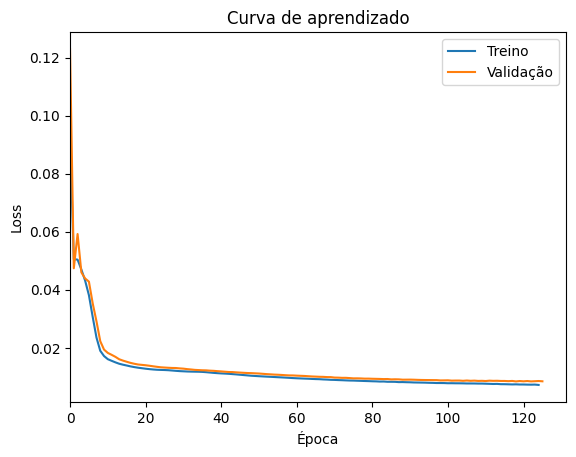

In [19]:
# Plotando curva de aprendizado

figura, eixo = plt.subplots()

ca_treino = minha_MLP.curva_aprendizado_treino
ca_val = minha_MLP.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

Usando a nova rede com esses hiperparâmetros, calculamos as métricas **RMSE** e o **R<sup>2</sup>** (coeficiente de determinação), como mostrado a seguir:

In [20]:
# Avaliando a nova rede

minha_MLP.eval()

with torch.no_grad():
    X_true = X_teste

    y_true = y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = minha_MLP(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    R2 = r2_score(y_true, y_pred)
    
    print("RMSE:", RMSE)
    print("R2:", R2)

RMSE: 0.7997893485513845
R2: 0.8660095866699589


Por fim, podemos perceber a dispersão com o plot a seguir:

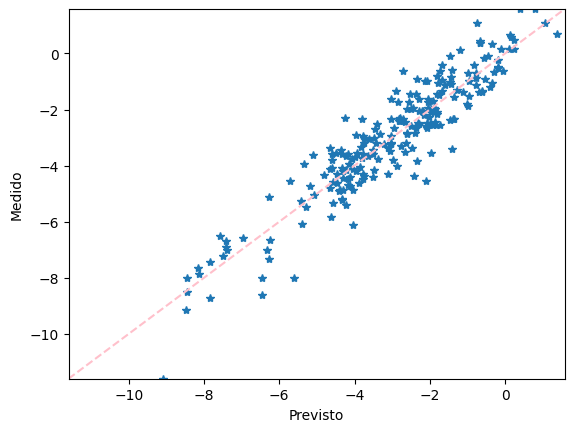

In [21]:
# Plotando curva de Previsto x Verdadeiro 

plt.plot(y_pred, y_true,"*")

min_valor = min([y_true.min(),y_pred.min()])
max_valor = max([y_true.max(),y_pred.max()])


plt.xlim(min_valor,max_valor)
plt.ylim(min_valor,max_valor)
plt.plot([min_valor,max_valor],[min_valor,max_valor],"--",color="pink")
plt.xlabel("Previsto")
plt.ylabel("Medido")
plt.show()

Neste gráfico, os valores medidos e previstos de logS são dados na unidade de mol/L.

## Conclusão

Conseguimos criar um modelo que consegue prever com um erro relativamente baixo a solubilidade das moléculas. A função de perda melhorou muito com a implementação do Optuna, o que pode ser observado analiticamente ou visualmente pelo plot que aproxima melhor os dados da função identidade. Assim, é interesante observar que as redes neurais conseguem modelar uma regressão do $LogS$ sem o que seria o parâmetro de maior significância, o $cLogP$. 

Obrigada por ler até aqui! Você ganhou uma dopamininha!

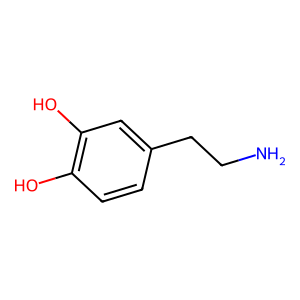

In [24]:
from rdkit.Chem import Draw
dopamininha_smiles = 'C1=CC(=C(C=C1CCN)O)O'
dopamininha = Chem.MolFromSmiles(dopamininha_smiles)
Draw.MolToImage(dopamininha)

## Referências

- [1] https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html
- [3] https://arxiv.org/abs/1703.00564
- [3] https://pubs.acs.org/doi/10.1021/ci034243x
- [4] https://lightning.ai/docs/pytorch/stable/
- [5] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
- [6] https://www.youtube.com/watch?v=nt5DwCuYY5c&t=288s
- [7] https://www.youtube.com/watch?v=p3CcfIjycBA&t=762s
- [8] https://optuna.org/
- [9] https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2023.1255181/full
- [10] https://github.com/dataprofessor/code/blob/master/python/cheminformatics_predicting_solubility.ipynb
- Material didático do curso de Redes Neurais e Algoritimos Genéticos disponibilizado para os discentes em 2024, Professor Daniel Cassar, Ilum - Escola de Ciência.